In [ ]:
# In this notebook, the neural network is used to make predictions on image samples 

In [1]:
# Import the necessary packages and libraries #
import ee
import folium ; from folium import plugins
import time
import scipy ; from scipy import stats
import sklearn ; from sklearn import linear_model ; from sklearn import preprocessing
import pickle
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy
import numpy.matlib
import pandas 
import tensorflow
from tensorflow import keras 
import os
from sklearn.neighbors import DistanceMetric
import random

# import custom modules:
import feature_collections as fc
import image_bands as ib
import wrapper_nets as wn
import ee_functions as ee_func

ee.Initialize()

In [2]:
# Sets the precision of the data in the Pandas Dataframes 

pandas.set_option("precision", 10)

In [3]:
# Removes any Tensorflow warnings 

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
# -----------------------------------
# INPUT PARAMETERS / SETUP: TO MODIFY
# -----------------------------------
outputName = 'LAI'
    # product name, one of: 'Surface_Reflectance','Albedo','fAPAR','fCOVER','LAI','CCC','CWC','DASF'

siteSelect = 'Geraldton'
    # site selection, one of: 'Ottawa', 'Geraldton', 'FoxCreek', 'Kouchibouguac'


# output parameters, outputScale and outputOffset not applied to "Surface_Reflectance"
outputParams = {
    'fAPAR': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 1
    },
    'fCOVER': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 1
    },
    'LAI': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 8
    }
}

outputScale = outputParams[outputName]['outputScale']
outputOffset = outputParams[outputName]['outputOffset']
outputMax = outputParams[outputName]['outputMax']


# specify parameters based on siteSelect: default image (Ottawa region), or one of three test sites:
siteParams = {
    # default region
    'Ottawa': {
        'inputImage': None,
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-75, 45], \
                          [-75, 46], \
                          [-74, 46], \
                          [-74, 45]]])
    },
    # Geraldton, ON
    'Geraldton': {
        'inputImage': ee.Image('COPERNICUS/S2_SR/20200811T164849_20200811T165525_T16UEA'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-95, 45], \
                          [-95, 55], \
                          [-80, 55], \
                          [-80, 45]]])
    },
    # Fox Creek, AB
    'FoxCreek': {
        'inputImage': ee.Image('COPERNICUS/S2_SR/20210825T185919_20210825T190431_T11UNA'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-117, 53], \
                          [-117, 53], \
                          [-115, 55], \
                          [-115, 54]]])
    },
    # Kouchibouguac, NB
    'Kouchibouguac': {
        'inputImage': ee.Image('COPERNICUS/S2_SR/20200905T151701_20200905T151829_T20TLS'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-65, 46], \
                          [-65, 47], \
                          [-64, 47], \
                          [-64, 46]]])
    },
    'Test': {
        'inputImage': ee.Image('COPERNICUS/S2_SR/20200102T184751_20200102T184752_T11UPU'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-115,53], \
                          [-114,53], \
                          [-114,54], \
                          [-115,54]]])
    }
}


#[-115.79669729915135,53.65596053367797]
#[-114.76947561946385,53.65596053367797]
#[-114.76947561946385,54.04480435119044]
#[-115.79669729915135,54.04480435119044]


mapBounds = siteParams[siteSelect]['mapBounds']
inputImage = siteParams[siteSelect]['inputImage']


# other filters (date filters apply to default region only)
maxCloudcover = 10
startDate = ee.Date('2020-08-01'),
endDate = ee.Date('2020-08-5')

# export parameters
exportFolder = siteSelect+'_'+outputName
exportScale = 20
exportDatatype = "int"

In [5]:
COLLECTION_OPTIONS = {
    # Sentinel 2 using 20 m bands:
    'COPERNICUS/S2_SR': {
      "name": 'COPERNICUS/S2_SR',
      "description": 'Sentinel 2A',
      "Cloudcover": 'CLOUDY_PIXEL_PERCENTAGE',
      "Watercover": 'WATER_PERCENTAGE',
      "sza": 'MEAN_SOLAR_ZENITH_ANGLE',
      "vza": 'MEAN_INCIDENCE_ZENITH_ANGLE_B8A',
      "saa": 'MEAN_SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(fc.s2_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(fc.s2_createFeatureCollection_errors()),  
      "sl2pDomain": ee.FeatureCollection(fc.s2_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(fc.s2_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(fc.s2_createImageCollection_partition()),
      "legend": ee.FeatureCollection(fc.s2_createFeatureCollection_legend()),
      "numVariables": 7
    },
    'LANDSAT/LC08/C01/T1_SR': {
      "name": 'LANDSAT/LC08/C01/T1_SR',
      "description": 'LANDSAT 8',
      "Cloudcover": 'CLOUD_COVER_LAND',
      "Watercover": 'CLOUD_COVER',
      "sza": 'SOLAR_ZENITH_ANGLE',
      "vza": 'SOLAR_ZENITH_ANGLE',
      "saa": 'SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'SOLAR_AZIMUTH_ANGLE',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(fc.l8_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(fc.l8_createFeatureCollection_errors()),
      "sl2pDomain": ee.FeatureCollection(fc.l8_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(fc.l8_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(fc.l8_createImageCollection_partition()),
      "legend": ee.FeatureCollection(fc.l8_createFeatureCollection_legend()),
      "numVariables": 7
    }
}

VIS_OPTIONS = {
    'fAPAR': {
        "COPERNICUS/S2_SR": {
            "Name": 'fAPAR',
            "errorName": 'errorfAPAR',
            "maskName": 'maskfAPAR',
            "description": 'Fraction of absorbed photosynthetically active radiation',
            "variable": 2,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    },
    'fCOVER': {
        "COPERNICUS/S2_SR": {
            "Name": 'fCOVER',
            "errorName": 'errorfCOVER',
            "maskName": 'maskfCOVER',
            "description": 'Fraction of canopy cover',
            "variable": 3,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]]))) 
        }
    },
    'LAI': {
        "COPERNICUS/S2_SR": {
            "Name": 'LAI',
            "errorName": 'errorLAI',
            "maskName": 'maskLAI',
            "description": 'Leaf area index',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
        }
}

In [6]:
# parse the networks
colName = 'COPERNICUS/S2_SR'
colOptions = COLLECTION_OPTIONS[colName]
netOptions = VIS_OPTIONS[outputName][colName]
numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[colName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,netNum));
errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2Perrors"],numNets,netNum));

### Original SL2P:

In [7]:
# filter collection and add ancillary bands
if siteSelect == 'Ottawa':
    input_collection = ee.ImageCollection(COLLECTION_OPTIONS[colName]["name"]) \
                         .filterBounds(mapBounds) \
                         .filterDate(startDate, endDate) \
                         .filterMetadata(colOptions["Cloudcover"],'less_than',maxCloudcover) \
                         .limit(5000) \
                         .map(lambda image: ib.addDate(image)) \
                         .map(lambda image: image.clip(mapBounds)) \
                         .map(lambda image: ib.s2MaskClear(image)) \
                         .map(lambda image: ib.s2MaskLand(image)) \
                         .map(lambda image: ib.addS2Geometry(colOptions, image))

else:
    input_collection = ee.ImageCollection(inputImage) \
                         .map(lambda image: ib.addDate(image)) \
                         .map(lambda image: image.clip(mapBounds)) \
                         .map(lambda image: ib.s2MaskClear(image)) \
                         .map(lambda image: ib.s2MaskLand(image)) \
                         .map(lambda image: ib.addS2Geometry(colOptions, image))

# get partition used to select network
partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition')
    
# pre process input imagery and flag invalid inputs
scaled_input_collection = input_collection.map(lambda image: ib.scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                       .map(lambda image: ib.invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))
    
# apply networks to produce mapped parameters
estimateSL2P = scaled_input_collection.map(lambda image: wn.wrapperNNets(SL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "estimate", image, outputName))
uncertaintySL2P = scaled_input_collection.map(lambda image: wn.wrapperNNets(errorsSL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "error", image, outputName))
    
# scale and offset mapped parameter bands
estimateSL2P = estimateSL2P.map(lambda image: image.addBands(image.select("estimate"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)), overwrite=True))
uncertaintySL2P = uncertaintySL2P.map(lambda image: image.addBands(image.select("error"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)), overwrite=True))
    
# produce final export collection
export_collection = input_collection.combine(estimateSL2P).combine(uncertaintySL2P)
    
image_output_names = ([name+"_"+outputName for name in export_collection.toList(export_collection.size()).map(lambda image: ee.Image(image).id()).getInfo()])
ee_func.displayImage(export_collection.mosaic().select('estimate'+outputName),0+outputOffset,10*outputScale+outputOffset, mapBounds)

### SL2P10_20m:

In [13]:
# reduces image resolution before applying algorithm
    
# filter collection and add ancillary bands
if siteSelect == 'Ottawa':
    input_collection_20m = ee.ImageCollection(COLLECTION_OPTIONS[colName]["name"]) \
                         .filterBounds(mapBounds) \
                         .filterDate(startDate, endDate) \
                         .filterMetadata(colOptions["Cloudcover"],'less_than',maxCloudcover) \
                         .limit(5000) \
                         .map(lambda image: ib.addDate(image)) \
                         .map(lambda image: image.clip(mapBounds)) \
                         .map(lambda image: ib.s2MaskClear(image)) \
                         .map(lambda image: ib.addS2Geometry(colOptions, image)) \
                         .map(lambda image: ib.reduceTo20m(image))

else:
    input_collection_20m = ee.ImageCollection(inputImage) \
                         .map(lambda image: ib.addDate(image)) \
                         .map(lambda image: image.clip(mapBounds)) \
                         .map(lambda image: ib.s2MaskClear(image)) \
                         .map(lambda image: ib.s2MaskLand(image)) \
                         .map(lambda image: ib.addS2Geometry(colOptions, image)) \
                         .map(lambda image: ib.reduceTo20m(image))


if outputName == "Surface_Reflectance":
    export_collection_20m = input_collection_20m
else:
    # get partition used to select network
    partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition')

    # pre process input imagery and flag invalid inputs
    input_collection_20m = input_collection_20m.map(lambda image: ib.s2MaskLand(image)) \
                                               .map(lambda image: ib.scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                               .map(lambda image: ib.invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))
    
    # apply networks to produce mapped parameters
    estimateSL2P_20m = input_collection_20m.map(lambda image: wn.wrapperNNets(SL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "estimate", image, outputName))
    uncertaintySL2P_20m = input_collection_20m.map(lambda image: wn.wrapperNNets(errorsSL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "error", image, outputName))

    # scale and offset mapped parameter bands
    estimateSL2P_20m = estimateSL2P_20m.map(lambda image: image.addBands(image.select("estimate"+outputName) \
                                                               .multiply(ee.Image.constant(outputScale)) \
                                                               .add(ee.Image.constant(outputOffset)), overwrite = True))
    uncertaintySL2P_20m = uncertaintySL2P_20m.map(lambda image: image.addBands(image.select("error"+outputName) \
                                                                     .multiply(ee.Image.constant(outputScale)) \
                                                                     .add(ee.Image.constant(outputOffset)),overwrite = True))
    
    # produce final export collection
    export_collection_20m = input_collection_20m.combine(estimateSL2P_20m).combine(uncertaintySL2P_20m)

image_output_names_20m = ([name+"_"+outputName+"_20m" for name in export_collection_20m.toList(export_collection_20m.size()).map(lambda image: ee.Image(image).id()).getInfo()])

ee_func.displayImage(export_collection_20m.mosaic().select('estimate'+outputName),0+outputOffset,4*outputScale+outputOffset, mapBounds)

In [9]:
# combine all SL2P, SL2P10_10m, SL2P10_20m bands into a single image to sample corresponding pixel values

export_20m = export_collection_20m.first()

export_20m = export_20m.select('estimate'+outputName).rename('estimate'+outputName+'_20m')

# get the first image in export_collection ; add all bands from corresponding image in export_collection_10m and export_collection_10m
full_image = export_collection.first().addBands(export_20m)

# sample the composed image with SL2P10_10m and SL2P10_20m bands
samples = full_image.select('estimate'+outputName).sample(numPixels=4000, projection=export_collection.first().select('estimate'+outputName)\
                                                             .projection(), scale=20).getInfo()

band_data = full_image.select(['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12']).sample(numPixels=4000, projection=export_collection.first().select('estimate'+outputName)\
                                                             .projection(), scale=20).getInfo()

bands = ['B3','B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12','cosVZA', 'cosSZA', 'cosRAA']

list_length = len(samples['features'])
estimate_list = []

# populate an array with the estimate for SL2P, SL2P10_10m, SL2P10_20m
for i in range(list_length):
    temp_list = []
    temp_list.append(samples['features'][i]['properties']['estimate'+outputName])
    estimate_list.append(temp_list)

band_array = numpy.empty((list_length,len(bands))) 

for idx, band in enumerate(bands):
    for k in range(list_length):
        band_array[k,idx] = band_data['features'][k]['properties'][band]
    
sl2p = pandas.DataFrame(estimate_list).rename(columns={0:'estimate'+outputName}).divide(outputScale)

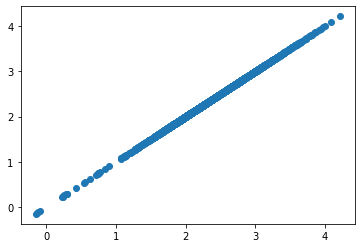

In [10]:
plt.scatter(sl2p, sl2p)

In [11]:
# Creates a dataframe from the band data

bands_df = pandas.DataFrame(data=band_array, columns = bands)

In [29]:
# Divide the data by 10000 so that the data is scaled appropriately 

bands_df = bands_df.divide(10000)

bands_df

,B3,B4,B5,B6,B7,B8A,B11,B12,cosVZA,cosSZA,cosRAA


In [30]:
# Subtract a certain amount from each column in the angle data so that it is more similar to the angle data in the matlab file 

a1_subtract = numpy.random.uniform(0.0, 0.05, size = bands_df.shape[0])
a2_subtract = numpy.random.uniform(0.0, 0.7, size = bands_df.shape[0])
a3_subtract = numpy.random.uniform(0.0, 2, size = bands_df.shape[0])

In [31]:
# Adjusts the angle data

bands_df['cosVZA'] =  bands_df['cosVZA'].subtract(a1_subtract)
bands_df['cosSZA'] =  bands_df['cosVZA'].subtract(a2_subtract)
bands_df['cosRAA'] =  bands_df['cosVZA'].subtract(a3_subtract)

In [ ]:
bands_df

In [ ]:
# Standardize the data 

bands_df_scaled = pandas.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(bands_df), columns=bands)

bands_df_scaled

In [ ]:
# Load the Neural Networks

LAI_model = keras.models.load_model('./models/LAI_models')
LAI_model_control = keras.models.load_model('./models/LAI_models_control')

In [ ]:
# Apply the Neural networks on the standardized band/angle data

LAI_image_predicted = LAI_model.predict(numpy.array(bands_df_scaled)).flatten()
LAI_image_predicted_control = LAI_model_control.predict(numpy.array(bands_df_scaled)).flatten()

In [ ]:
LAI_image_predicted

In [ ]:
LAI_image_predicted_control

In [ ]:
# Resizes the sl2p data

sl2p = numpy.resize(sl2p, len(LAI_image_predicted))

In [ ]:
# Gets the mean and std for the LAI from the calibration data in steps 6+7

scaling_data = pandas.read_csv('scale_data.csv')

# These values are used to descale the predicted LAI values

LAI_mean = float(scaling_data.columns[0])

LAI_std = float(scaling_data.columns[1])

In [ ]:
r_min_control = min(LAI_image_predicted_control)
r_max_control = max(LAI_image_predicted_control)
r_min = min(LAI_image_predicted)
r_max = max(LAI_image_predicted)
t_min = 0
t_max = 8

scaled_LAI_control = ((LAI_image_predicted_control - r_min_control)/(r_max_control - r_min_control))*(t_max-t_min) + t_min
scaled_LAI = ((LAI_image_predicted - r_min)/(r_max - r_min))*(t_max-t_min) + t_min

In [ ]:
# get the first image in export_collection ; add all bands from corresponding image in export_collection_10m and export_collection_10m
full_image = export_collection.first().addBands(export_20m)

# sample the composed image with SL2P10_10m and SL2P10_20m bands
samples = full_image.select('estimate'+outputName).sample(numPixels=4000, projection=export_collection.first().select('estimate'+outputName)\
                                                             .projection(), scale=20).getInfo()

band_data = full_image.select(['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12']).sample(numPixels=4000, projection=export_collection.first().select('estimate'+outputName)\
                                                             .projection(), scale=20).getInfo()

In [ ]:
# Function that creates a density plot

def plotting_function(var, input_var, resp_var, title, xlabel, ylabel, alg, ax=None):
    ax = ax
    xy = numpy.vstack([input_var, resp_var])
    z = scipy.stats.gaussian_kde(xy)(xy)
    idx = z.argsort()
    x = input_var[idx]
    y = resp_var[idx]
    z = z[idx]
    rmse = sklearn.metrics.mean_squared_error(x, y, squared=False)
    r_sqr = sklearn.metrics.r2_score(x, y)
    ax.scatter(x, y, c = z)
    plt.colorbar(mappable=ax.scatter(x, y, c = z), ax=ax)
    ax.set_title(title + '-' + alg + ' - RMSE: {}'.format(rmse) + ' - $R^2$: {}'.format(r_sqr))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

In [ ]:
# This cell creates the plots that compare when we use weights in the NNet vs not using weights

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,15))

plotting_function('LAI', sl2p, scaled_LAI, 'LAI','SL2P LAI','NNet LAI','SL2P vs NNet', ax1)

plotting_function('LAI', sl2p, scaled_LAI_control, 'LAI','SL2P LAI','NNet LAI','SL2P vs NNet - Control', ax2)
  
fig.suptitle('SL2P vs NNet', fontsize=24)